In [1]:
import torch
import sys
import os
import os.path as osp
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import ticker
import matplotlib as mpl
from matplotlib.colors import LogNorm
import matplotlib.patches as mpatches
from sklearn.metrics import precision_recall_curve, recall_score, precision_score, \
balanced_accuracy_score, accuracy_score
from sklearn import metrics
from IPython.display import display
import math
from dataclasses import dataclass
import allel

In [2]:
os.environ['USER_PATH']='/home/users/richras/Ge2Net_Repo'
os.environ['USER_SCRATCH_PATH']="/scratch/users/richras"
os.environ['IN_PATH']='/scratch/groups/cdbustam/richras/data_in'
os.environ['OUT_PATH']='/scratch/groups/cdbustam/richras/data_out'
os.environ['LOG_PATH']='/scratch/groups/cdbustam/richras/logs/'

In [3]:
os.chdir(os.environ.get('USER_PATH'))

In [4]:
%load_ext autoreload
%autoreload 2
from src.utils.dataUtil import load_path, save_file, vcf2npy
from src.utils.modelUtil import Params, load_model, convert_coordinates, convert_nVector
from src.utils.labelUtil import nearestNeighbourMapping, repeat_pop_arr
from src.utils.decorators import timer
from src.main.visualization import plot_coordinates_map, plot_sample, plot_changepoints
from src.models.modelSelection import modelSelect
from src.models.modelParamsSelection import Selections
from src.models import Model_A, Model_B, Model_C, BOCD
from src.models.distributions import Multivariate_Gaussian
from src.main.evaluation import eval_cp_batch, reportChangePointMetrics, t_prMetrics, cpMethod, eval_cp_matrix, \
getCpPred, GcdLoss, balancedMetrics, class_accuracy, Running_Average
from src.main.settings_model import parse_args
from src.models.Ge3Net import Ge3NetBase
import inference

# load the model and use valid data 

In [5]:
def rmAdditionalWin(pred_cps_BOCD):
    cpIdx=np.nonzero(pred_cps_BOCD)[0]
    remWin=3
    seqlen=317
    for i in cpIdx:
        low=max(0,i-remWin)
        high=min(seqlen, i+remWin)
        pred_cps_BOCD[low:high]=1
    return pred_cps_BOCD


In [6]:
@dataclass
class balancedMetrics():
    def __init__(self):
        self.batchMetricLs=[]
        self.classSuperpop= {}
        self.classGranularpop={}
    
    def fillData(self, dataTensor):
        self.batchMetricLs.append(dataTensor)

    def balancedMetric(self, superpop, granular_pop):
        gcdTensor = self.batchMetricLs[-1]
        superpop_num=np.unique(superpop).astype(int)
        granularpop_num=np.unique(granular_pop).astype(int)
        for i in superpop_num:
            if self.classSuperpop.get(i) is None: self.classSuperpop[i]=Running_Average()
            idx=np.nonzero(superpop==i)
            self.classSuperpop[i].update(np.sum(gcdTensor[idx[0], idx[1]]), len(idx[0]))
            
        for i in granularpop_num:
            if self.classGranularpop.get(i) is None: self.classGranularpop[i]=Running_Average()
            idx=np.nonzero(granular_pop==i)
            self.classGranularpop[i].update(np.sum(gcdTensor[idx[0], idx[1]]), len(idx[0]))             
                
    def meanBalanced(self):
        meanBalancedSuperpop={k:self.classSuperpop[k]() for k in self.classSuperpop.keys()}
        meanBalancedGranularpop={k:self.classGranularpop[k]() for k in self.classGranularpop.keys()}
        return meanBalancedSuperpop, meanBalancedGranularpop

In [7]:
data_id=['data_id_4_geo', 'data_id_4_geo', 'data_id_4_geo']
model_id_data_id=['Model_Q_exp_id_3_data_id_4_geo', 'Model_Q_exp_id_31_data_id_4_geo','Model_Q_exp_id_37_data_id_4_geo']

geno_type="humans"
def loadModelStats(data_id, model_id_data_id, dataset_type):
    results = {}
    
    for d, m in zip(data_id, model_id_data_id):
        results_gen = {}
        labels_path = osp.join(os.environ['OUT_PATH'], geno_type, 'labels', d)
        data_path = osp.join(os.environ['OUT_PATH'], geno_type, 'labels', d)
        models_path = osp.join(os.environ['OUT_PATH'], geno_type, 'training', m)
        config = {}
        config['data.labels']=labels_path 
        config['data.dir']=data_path 
        config['models.dir']=models_path
        config['data.dataset_type']=dataset_type
        config['cuda']='cuda'
        config['model.loadBest']=True
        yaml_path = osp.join(config['models.dir'], 'params.yaml')
        assert osp.isfile(yaml_path), "No yaml configuration file found at {}".format(yaml_path)
        params = Params(yaml_path)
        params.rtnOuts=True
        params.mc_dropout=False
        params.mc_samples=100
        params.cp_tol=1
        params.evalCp=True
        params.evalBalancedGcd=True
        params.evalExtraMainLosses=True
        list_all_gens = params.valid_gens
        
        balancedMetricsObj_allGens=balancedMetrics()
        for gen in [[0], [2], [4], [8], [16], [32], [64]]:
            if gen[0] not in list_all_gens:
                continue
            loss_main={}
            params.test_gens=gen
            params.valid_gens=gen
            Stats_gen, dataset, _, trainingStats = inference.main(config, params)
            
            print(f"num_samples for gen {gen} ={Stats_gen.t_out.coord_main.shape[1]}")
            trueCp=dataset.data['cps']
            trueCpMask=(trueCp==0)
            superpop = dataset.data['superpop']
            granular_pop = dataset.data['granular_pop']
            
            #BOCD
            y_pred = Stats_gen.t_out.coord_main.squeeze(0)
            n_vec_dim = y_pred.shape[-1]
            data_tensor = torch.tensor(y_pred).float()
            batch_size_cpd = data_tensor.shape[0]
            mu_prior = torch.zeros((batch_size_cpd, 1,n_vec_dim))
            mean_var = torch.mean(torch.var(data_tensor, dim =1),dim=0).unsqueeze(0)
            cov_prior = (mean_var.repeat(batch_size_cpd,1).unsqueeze(1)* torch.eye(n_vec_dim)).reshape(batch_size_cpd,1,n_vec_dim,n_vec_dim)
            cov_x = cov_prior
            likelihood_model = Multivariate_Gaussian(mu_prior, cov_prior, cov_x)
            T = params.n_win
            model_cpd = BOCD.BOCD(None, T, likelihood_model, batch_size_cpd)
            posterior, _, predictive, e_mean = model_cpd.run_recursive(data_tensor, 'cpu')
            
            predCp=getCpPred(cpMethod.BOCD.name, model_cpd.cp, cpThresh=2.0, \
            Batch_size=Stats_gen.t_out.coord_main.shape[1], \
            T=Stats_gen.t_out.coord_main.shape[2])
            predCp=predCp.detach().cpu().numpy()
            predCpMask=(predCp==0)
            predCp = np.apply_along_axis(rmAdditionalWin, 1, predCp)
            predCpMask=predCpMask
            intersectSum=trueCp+predCp
            intersectCp=(intersectSum!=2)
            loss_main['no_mask']= Stats_gen.t_accr['loss_main']
            coord_main=Stats_gen.t_out.coord_main.squeeze(0)
            loss_main['trueCpMask']= GcdLoss()(coord_main,\
                                    dataset.data['y'], mask=trueCpMask[...,np.newaxis])/trueCpMask.sum()

            loss_main['intersectCpMask']=GcdLoss()(coord_main,\
                                    dataset.data['y'], mask=intersectCp[...,np.newaxis])/intersectCp.sum()
            loss_main['predCpMask']= GcdLoss()(coord_main,\
                                    dataset.data['y'], mask=predCpMask[...,np.newaxis])/predCpMask.sum()
            results_gen[str(gen)]={'meanBalancedGcdGp':Stats_gen.t_balanced_gcd['meanBalancedGcdGp']}
            results_gen[str(gen)]['loss_main_w_masks']=loss_main
            results_gen[str(gen)]['num_samples'] = Stats_gen.t_out.coord_main.shape[1]
            # calculated balancedGcd by granular pop
            balancedMetricsObj=balancedMetrics()
            loss_tensor = GcdLoss().rawGcd(Stats_gen.t_out.coord_main.squeeze(0), dataset.data['y'])
            balancedMetricsObj.fillData(loss_tensor)
            balancedMetricsObj.balancedMetric(superpop, granular_pop)
            _, results_gen[str(gen)]['balancedGcdMatrix']=balancedMetricsObj.meanBalanced()
            
            balancedMetricsObj_allGens.fillData(loss_tensor)
            balancedMetricsObj_allGens.balancedMetric(superpop, granular_pop)
        
        results[m]=results_gen
        
        _, results[m]['balancedGcdMatrix_allGens'] = balancedMetricsObj_allGens.meanBalanced()
        
        
    return results

In [8]:
results_test = loadModelStats(data_id, model_id_data_id, dataset_type="test")
results_valid = loadModelStats(data_id, model_id_data_id, dataset_type="valid")

INFO: __init__:src.main.dataset: Loading test Dataset
INFO: __init__:src.main.dataset:Loading gen 0


 device used: cuda
Loading the datasets...


INFO: __init__:src.main.dataset: snps data: (540, 317410)
INFO: __init__:src.main.dataset: y_labels data :(540, 317410)
INFO: transform_data:src.main.dataset:Transforming the data


Finished '_geoConvertLatLong2nVec' in 0.0108 secs
Finished 'mapping_func' in 0.0563 secs
Finished 'pop_mapping' in 0.0243 secs
Finished 'pop_mapping' in 0.0237 secs
Finished 'transform_data' in 5.8999 secs
Finished '__init__' in 30.0839 secs
Parameter count for model AuxNetwork:31747503
Parameter count for model TransformerModel:107528
Parameter count for model BiRNN:34499
Parameter count for model logits_Block:2289
Total parameters:31891819
Finished 'load_model' in 15.0937 secs
best val loss metrics : {'loss_main': 866.6805836590546, 'loss_aux': 2160.2513772460106, 'l1_loss': 0.20087590047931303, 'mse': 0.045047710068923504, 'smooth_l1': 0.022466416130238673, 'weighted_loss': 0.20087590047931303}
at epoch : 227
train loss metrics: {'loss_main': 260.368462953392, 'loss_aux': 1561.6972164885574, 'l1_loss': 0.05821169218555197, 'mse': 0.005354038258400175, 'smooth_l1': 0.0026711223615385584, 'weighted_loss': 0.05821169218555197}
best val cp metrics : {'loss_cp': 0.49852718259127005, 'prM

INFO: __init__:src.main.dataset: Loading test Dataset
INFO: __init__:src.main.dataset:Loading gen 2


Finished 'run_recursive' in 27.5236 secs
 device used: cuda
Loading the datasets...


INFO: __init__:src.main.dataset: snps data: (800, 317410)
INFO: __init__:src.main.dataset: y_labels data :(800, 317410)
INFO: transform_data:src.main.dataset:Transforming the data


Finished '_geoConvertLatLong2nVec' in 0.0156 secs
Finished 'mapping_func' in 0.0818 secs
Finished 'pop_mapping' in 0.0354 secs
Finished 'pop_mapping' in 0.0350 secs
Finished 'transform_data' in 8.7564 secs
Finished '__init__' in 26.9854 secs
Parameter count for model AuxNetwork:31747503
Parameter count for model TransformerModel:107528
Parameter count for model BiRNN:34499
Parameter count for model logits_Block:2289
Total parameters:31891819
Finished 'load_model' in 0.1523 secs
best val loss metrics : {'loss_main': 866.6805836590546, 'loss_aux': 2160.2513772460106, 'l1_loss': 0.20087590047931303, 'mse': 0.045047710068923504, 'smooth_l1': 0.022466416130238673, 'weighted_loss': 0.20087590047931303}
at epoch : 227
train loss metrics: {'loss_main': 260.368462953392, 'loss_aux': 1561.6972164885574, 'l1_loss': 0.05821169218555197, 'mse': 0.005354038258400175, 'smooth_l1': 0.0026711223615385584, 'weighted_loss': 0.05821169218555197}
best val cp metrics : {'loss_cp': 0.49852718259127005, 'prMe

INFO: __init__:src.main.dataset: Loading test Dataset
INFO: __init__:src.main.dataset:Loading gen 4


 device used: cuda
Loading the datasets...


INFO: __init__:src.main.dataset: snps data: (800, 317410)
INFO: __init__:src.main.dataset: y_labels data :(800, 317410)
INFO: transform_data:src.main.dataset:Transforming the data


Finished '_geoConvertLatLong2nVec' in 0.0150 secs
Finished 'mapping_func' in 0.0816 secs
Finished 'pop_mapping' in 0.0351 secs
Finished 'pop_mapping' in 0.0347 secs
Finished 'transform_data' in 8.7719 secs
Finished '__init__' in 22.8486 secs
Parameter count for model AuxNetwork:31747503
Parameter count for model TransformerModel:107528
Parameter count for model BiRNN:34499
Parameter count for model logits_Block:2289
Total parameters:31891819
Finished 'load_model' in 0.1560 secs
best val loss metrics : {'loss_main': 866.6805836590546, 'loss_aux': 2160.2513772460106, 'l1_loss': 0.20087590047931303, 'mse': 0.045047710068923504, 'smooth_l1': 0.022466416130238673, 'weighted_loss': 0.20087590047931303}
at epoch : 227
train loss metrics: {'loss_main': 260.368462953392, 'loss_aux': 1561.6972164885574, 'l1_loss': 0.05821169218555197, 'mse': 0.005354038258400175, 'smooth_l1': 0.0026711223615385584, 'weighted_loss': 0.05821169218555197}
best val cp metrics : {'loss_cp': 0.49852718259127005, 'prMe

INFO: __init__:src.main.dataset: Loading test Dataset
INFO: __init__:src.main.dataset:Loading gen 8


 device used: cuda
Loading the datasets...


INFO: __init__:src.main.dataset: snps data: (800, 317410)
INFO: __init__:src.main.dataset: y_labels data :(800, 317410)
INFO: transform_data:src.main.dataset:Transforming the data


Finished '_geoConvertLatLong2nVec' in 0.0155 secs
Finished 'mapping_func' in 0.0819 secs
Finished 'pop_mapping' in 0.0358 secs
Finished 'pop_mapping' in 0.0350 secs
Finished 'transform_data' in 8.7216 secs
Finished '__init__' in 22.9224 secs
Parameter count for model AuxNetwork:31747503
Parameter count for model TransformerModel:107528
Parameter count for model BiRNN:34499
Parameter count for model logits_Block:2289
Total parameters:31891819
Finished 'load_model' in 0.1497 secs
best val loss metrics : {'loss_main': 866.6805836590546, 'loss_aux': 2160.2513772460106, 'l1_loss': 0.20087590047931303, 'mse': 0.045047710068923504, 'smooth_l1': 0.022466416130238673, 'weighted_loss': 0.20087590047931303}
at epoch : 227
train loss metrics: {'loss_main': 260.368462953392, 'loss_aux': 1561.6972164885574, 'l1_loss': 0.05821169218555197, 'mse': 0.005354038258400175, 'smooth_l1': 0.0026711223615385584, 'weighted_loss': 0.05821169218555197}
best val cp metrics : {'loss_cp': 0.49852718259127005, 'prMe

INFO: __init__:src.main.dataset: Loading test Dataset
INFO: __init__:src.main.dataset:Loading gen 0
INFO: __init__:src.main.dataset: snps data: (540, 317410)


 device used: cuda
Loading the datasets...


INFO: __init__:src.main.dataset: y_labels data :(540, 317410)
INFO: transform_data:src.main.dataset:Transforming the data


Finished '_geoConvertLatLong2nVec' in 0.0100 secs
Finished 'mapping_func' in 0.0550 secs
Finished 'pop_mapping' in 0.0239 secs
Finished 'pop_mapping' in 0.0244 secs
Finished 'transform_data' in 5.8601 secs
Finished '__init__' in 6.3502 secs
Parameter count for model AuxNetwork:31747503
Parameter count for model TransformerModel:133256
Parameter count for model BiRNN:34499
Parameter count for model logits_Block:2289
Total parameters:31917547
Finished 'load_model' in 0.5047 secs
best val loss metrics : {'loss_main': 837.5976891592411, 'loss_aux': 2177.4945391933843, 'l1_loss': 0.19298167763685006, 'mse': 0.044127899415007554, 'smooth_l1': 0.02203047697393506, 'weighted_loss': 0.19298167763685006}
at epoch : 183
train loss metrics: {'loss_main': 275.2866365127619, 'loss_aux': 1618.251100275109, 'l1_loss': 0.061813042006208345, 'mse': 0.0061231461747121955, 'smooth_l1': 0.0030536770945753505, 'weighted_loss': 0.061813042006208345}
best val cp metrics : {'loss_cp': 0.6768083546138789, 'prMe

INFO: __init__:src.main.dataset: Loading test Dataset
INFO: __init__:src.main.dataset:Loading gen 2


Finished 'run_recursive' in 27.4605 secs
 device used: cuda
Loading the datasets...


INFO: __init__:src.main.dataset: snps data: (800, 317410)
INFO: __init__:src.main.dataset: y_labels data :(800, 317410)
INFO: transform_data:src.main.dataset:Transforming the data


Finished '_geoConvertLatLong2nVec' in 0.0156 secs
Finished 'mapping_func' in 0.0832 secs
Finished 'pop_mapping' in 0.0360 secs
Finished 'pop_mapping' in 0.0341 secs
Finished 'transform_data' in 8.7782 secs
Finished '__init__' in 9.4419 secs
Parameter count for model AuxNetwork:31747503
Parameter count for model TransformerModel:133256
Parameter count for model BiRNN:34499
Parameter count for model logits_Block:2289
Total parameters:31917547
Finished 'load_model' in 0.1505 secs
best val loss metrics : {'loss_main': 837.5976891592411, 'loss_aux': 2177.4945391933843, 'l1_loss': 0.19298167763685006, 'mse': 0.044127899415007554, 'smooth_l1': 0.02203047697393506, 'weighted_loss': 0.19298167763685006}
at epoch : 183
train loss metrics: {'loss_main': 275.2866365127619, 'loss_aux': 1618.251100275109, 'l1_loss': 0.061813042006208345, 'mse': 0.0061231461747121955, 'smooth_l1': 0.0030536770945753505, 'weighted_loss': 0.061813042006208345}
best val cp metrics : {'loss_cp': 0.6768083546138789, 'prMe

INFO: __init__:src.main.dataset: Loading test Dataset
INFO: __init__:src.main.dataset:Loading gen 4
INFO: __init__:src.main.dataset: snps data: (800, 317410)


 device used: cuda
Loading the datasets...


INFO: __init__:src.main.dataset: y_labels data :(800, 317410)
INFO: transform_data:src.main.dataset:Transforming the data


Finished '_geoConvertLatLong2nVec' in 0.0150 secs
Finished 'mapping_func' in 0.0825 secs
Finished 'pop_mapping' in 0.0365 secs
Finished 'pop_mapping' in 0.0347 secs
Finished 'transform_data' in 8.7247 secs
Finished '__init__' in 9.3842 secs
Parameter count for model AuxNetwork:31747503
Parameter count for model TransformerModel:133256
Parameter count for model BiRNN:34499
Parameter count for model logits_Block:2289
Total parameters:31917547
Finished 'load_model' in 0.1501 secs
best val loss metrics : {'loss_main': 837.5976891592411, 'loss_aux': 2177.4945391933843, 'l1_loss': 0.19298167763685006, 'mse': 0.044127899415007554, 'smooth_l1': 0.02203047697393506, 'weighted_loss': 0.19298167763685006}
at epoch : 183
train loss metrics: {'loss_main': 275.2866365127619, 'loss_aux': 1618.251100275109, 'l1_loss': 0.061813042006208345, 'mse': 0.0061231461747121955, 'smooth_l1': 0.0030536770945753505, 'weighted_loss': 0.061813042006208345}
best val cp metrics : {'loss_cp': 0.6768083546138789, 'prMe

INFO: __init__:src.main.dataset: Loading test Dataset
INFO: __init__:src.main.dataset:Loading gen 8
INFO: __init__:src.main.dataset: snps data: (800, 317410)


 device used: cuda
Loading the datasets...


INFO: __init__:src.main.dataset: y_labels data :(800, 317410)
INFO: transform_data:src.main.dataset:Transforming the data


Finished '_geoConvertLatLong2nVec' in 0.0156 secs
Finished 'mapping_func' in 0.0829 secs
Finished 'pop_mapping' in 0.0369 secs
Finished 'pop_mapping' in 0.0347 secs
Finished 'transform_data' in 8.7446 secs
Finished '__init__' in 9.4083 secs
Parameter count for model AuxNetwork:31747503
Parameter count for model TransformerModel:133256
Parameter count for model BiRNN:34499
Parameter count for model logits_Block:2289
Total parameters:31917547
Finished 'load_model' in 0.1525 secs
best val loss metrics : {'loss_main': 837.5976891592411, 'loss_aux': 2177.4945391933843, 'l1_loss': 0.19298167763685006, 'mse': 0.044127899415007554, 'smooth_l1': 0.02203047697393506, 'weighted_loss': 0.19298167763685006}
at epoch : 183
train loss metrics: {'loss_main': 275.2866365127619, 'loss_aux': 1618.251100275109, 'l1_loss': 0.061813042006208345, 'mse': 0.0061231461747121955, 'smooth_l1': 0.0030536770945753505, 'weighted_loss': 0.061813042006208345}
best val cp metrics : {'loss_cp': 0.6768083546138789, 'prMe

INFO: __init__:src.main.dataset: Loading test Dataset
INFO: __init__:src.main.dataset:Loading gen 0
INFO: __init__:src.main.dataset: snps data: (540, 317410)


 device used: cuda
Loading the datasets...


INFO: __init__:src.main.dataset: y_labels data :(540, 317410)
INFO: transform_data:src.main.dataset:Transforming the data


Finished '_geoConvertLatLong2nVec' in 0.0099 secs
Finished 'mapping_func' in 0.0557 secs
Finished 'pop_mapping' in 0.0241 secs
Finished 'pop_mapping' in 0.0237 secs
Finished 'transform_data' in 5.8400 secs
Finished '__init__' in 6.3076 secs
Parameter count for model AuxNetwork:31747503
Parameter count for model TransformerModel:133256
Parameter count for model BiRNN:34499
Parameter count for model logits_Block:2289
Total parameters:31917547
Finished 'load_model' in 0.4556 secs
best val loss metrics : {'loss_main': 836.0798488485595, 'loss_aux': 2152.1262835094954, 'l1_loss': 0.19240272414547907, 'mse': 0.04447463351996686, 'smooth_l1': 0.022191767132209692, 'weighted_loss': 0.19240272414547907}
at epoch : 238
train loss metrics: {'loss_main': 218.46175901968778, 'loss_aux': 1485.8314123327116, 'l1_loss': 0.046999104912408475, 'mse': 0.003854911350544717, 'smooth_l1': 0.0019230075228341427, 'weighted_loss': 0.046999104912408475}
best val cp metrics : {'loss_cp': 0.019878406516587763, 'p

INFO: __init__:src.main.dataset: Loading test Dataset
INFO: __init__:src.main.dataset:Loading gen 2


Finished 'run_recursive' in 27.4689 secs
 device used: cuda
Loading the datasets...


INFO: __init__:src.main.dataset: snps data: (800, 317410)
INFO: __init__:src.main.dataset: y_labels data :(800, 317410)
INFO: transform_data:src.main.dataset:Transforming the data


Finished '_geoConvertLatLong2nVec' in 0.0149 secs
Finished 'mapping_func' in 0.0800 secs
Finished 'pop_mapping' in 0.0351 secs
Finished 'pop_mapping' in 0.0347 secs
Finished 'transform_data' in 8.7914 secs
Finished '__init__' in 9.4355 secs
Parameter count for model AuxNetwork:31747503
Parameter count for model TransformerModel:133256
Parameter count for model BiRNN:34499
Parameter count for model logits_Block:2289
Total parameters:31917547
Finished 'load_model' in 0.1550 secs
best val loss metrics : {'loss_main': 836.0798488485595, 'loss_aux': 2152.1262835094954, 'l1_loss': 0.19240272414547907, 'mse': 0.04447463351996686, 'smooth_l1': 0.022191767132209692, 'weighted_loss': 0.19240272414547907}
at epoch : 238
train loss metrics: {'loss_main': 218.46175901968778, 'loss_aux': 1485.8314123327116, 'l1_loss': 0.046999104912408475, 'mse': 0.003854911350544717, 'smooth_l1': 0.0019230075228341427, 'weighted_loss': 0.046999104912408475}
best val cp metrics : {'loss_cp': 0.019878406516587763, 'p

INFO: __init__:src.main.dataset: Loading test Dataset
INFO: __init__:src.main.dataset:Loading gen 4
INFO: __init__:src.main.dataset: snps data: (800, 317410)


 device used: cuda
Loading the datasets...


INFO: __init__:src.main.dataset: y_labels data :(800, 317410)
INFO: transform_data:src.main.dataset:Transforming the data


Finished '_geoConvertLatLong2nVec' in 0.0157 secs
Finished 'mapping_func' in 0.0830 secs
Finished 'pop_mapping' in 0.0361 secs
Finished 'pop_mapping' in 0.0344 secs
Finished 'transform_data' in 8.7907 secs
Finished '__init__' in 9.4188 secs
Parameter count for model AuxNetwork:31747503
Parameter count for model TransformerModel:133256
Parameter count for model BiRNN:34499
Parameter count for model logits_Block:2289
Total parameters:31917547
Finished 'load_model' in 0.1529 secs
best val loss metrics : {'loss_main': 836.0798488485595, 'loss_aux': 2152.1262835094954, 'l1_loss': 0.19240272414547907, 'mse': 0.04447463351996686, 'smooth_l1': 0.022191767132209692, 'weighted_loss': 0.19240272414547907}
at epoch : 238
train loss metrics: {'loss_main': 218.46175901968778, 'loss_aux': 1485.8314123327116, 'l1_loss': 0.046999104912408475, 'mse': 0.003854911350544717, 'smooth_l1': 0.0019230075228341427, 'weighted_loss': 0.046999104912408475}
best val cp metrics : {'loss_cp': 0.019878406516587763, 'p

INFO: __init__:src.main.dataset: Loading test Dataset
INFO: __init__:src.main.dataset:Loading gen 8
INFO: __init__:src.main.dataset: snps data: (800, 317410)


 device used: cuda
Loading the datasets...


INFO: __init__:src.main.dataset: y_labels data :(800, 317410)
INFO: transform_data:src.main.dataset:Transforming the data


Finished '_geoConvertLatLong2nVec' in 0.0157 secs
Finished 'mapping_func' in 0.0853 secs
Finished 'pop_mapping' in 0.0355 secs
Finished 'pop_mapping' in 0.0352 secs
Finished 'transform_data' in 8.7626 secs
Finished '__init__' in 9.3901 secs
Parameter count for model AuxNetwork:31747503
Parameter count for model TransformerModel:133256
Parameter count for model BiRNN:34499
Parameter count for model logits_Block:2289
Total parameters:31917547
Finished 'load_model' in 0.1523 secs
best val loss metrics : {'loss_main': 836.0798488485595, 'loss_aux': 2152.1262835094954, 'l1_loss': 0.19240272414547907, 'mse': 0.04447463351996686, 'smooth_l1': 0.022191767132209692, 'weighted_loss': 0.19240272414547907}
at epoch : 238
train loss metrics: {'loss_main': 218.46175901968778, 'loss_aux': 1485.8314123327116, 'l1_loss': 0.046999104912408475, 'mse': 0.003854911350544717, 'smooth_l1': 0.0019230075228341427, 'weighted_loss': 0.046999104912408475}
best val cp metrics : {'loss_cp': 0.019878406516587763, 'p

INFO: __init__:src.main.dataset: Loading valid Dataset
INFO: __init__:src.main.dataset:Loading gen 0


 device used: cuda
Loading the datasets...


INFO: __init__:src.main.dataset: snps data: (612, 317410)
INFO: __init__:src.main.dataset: y_labels data :(612, 317410)
INFO: transform_data:src.main.dataset:Transforming the data


Finished '_geoConvertLatLong2nVec' in 0.0113 secs
Finished 'mapping_func' in 0.0628 secs
Finished 'pop_mapping' in 0.0268 secs
Finished 'pop_mapping' in 0.0266 secs
Finished 'transform_data' in 6.7173 secs
Finished '__init__' in 19.0957 secs
Parameter count for model AuxNetwork:31747503
Parameter count for model TransformerModel:107528
Parameter count for model BiRNN:34499
Parameter count for model logits_Block:2289
Total parameters:31891819
Finished 'load_model' in 0.1775 secs
best val loss metrics : {'loss_main': 866.6805836590546, 'loss_aux': 2160.2513772460106, 'l1_loss': 0.20087590047931303, 'mse': 0.045047710068923504, 'smooth_l1': 0.022466416130238673, 'weighted_loss': 0.20087590047931303}
at epoch : 227
train loss metrics: {'loss_main': 260.368462953392, 'loss_aux': 1561.6972164885574, 'l1_loss': 0.05821169218555197, 'mse': 0.005354038258400175, 'smooth_l1': 0.0026711223615385584, 'weighted_loss': 0.05821169218555197}
best val cp metrics : {'loss_cp': 0.49852718259127005, 'prMe

INFO: __init__:src.main.dataset: Loading valid Dataset
INFO: __init__:src.main.dataset:Loading gen 2


 device used: cuda
Loading the datasets...


INFO: __init__:src.main.dataset: snps data: (800, 317410)
INFO: __init__:src.main.dataset: y_labels data :(800, 317410)
INFO: transform_data:src.main.dataset:Transforming the data


Finished '_geoConvertLatLong2nVec' in 0.0148 secs
Finished 'mapping_func' in 0.0818 secs
Finished 'pop_mapping' in 0.0363 secs
Finished 'pop_mapping' in 0.0343 secs
Finished 'transform_data' in 8.7623 secs
Finished '__init__' in 27.4743 secs
Parameter count for model AuxNetwork:31747503
Parameter count for model TransformerModel:107528
Parameter count for model BiRNN:34499
Parameter count for model logits_Block:2289
Total parameters:31891819
Finished 'load_model' in 0.1494 secs
best val loss metrics : {'loss_main': 866.6805836590546, 'loss_aux': 2160.2513772460106, 'l1_loss': 0.20087590047931303, 'mse': 0.045047710068923504, 'smooth_l1': 0.022466416130238673, 'weighted_loss': 0.20087590047931303}
at epoch : 227
train loss metrics: {'loss_main': 260.368462953392, 'loss_aux': 1561.6972164885574, 'l1_loss': 0.05821169218555197, 'mse': 0.005354038258400175, 'smooth_l1': 0.0026711223615385584, 'weighted_loss': 0.05821169218555197}
best val cp metrics : {'loss_cp': 0.49852718259127005, 'prMe

INFO: __init__:src.main.dataset: Loading valid Dataset
INFO: __init__:src.main.dataset:Loading gen 4


 device used: cuda
Loading the datasets...


INFO: __init__:src.main.dataset: snps data: (800, 317410)
INFO: __init__:src.main.dataset: y_labels data :(800, 317410)
INFO: transform_data:src.main.dataset:Transforming the data


Finished '_geoConvertLatLong2nVec' in 0.0157 secs
Finished 'mapping_func' in 0.0830 secs
Finished 'pop_mapping' in 0.0361 secs
Finished 'pop_mapping' in 0.0345 secs
Finished 'transform_data' in 8.7715 secs
Finished '__init__' in 20.9837 secs
Parameter count for model AuxNetwork:31747503
Parameter count for model TransformerModel:107528
Parameter count for model BiRNN:34499
Parameter count for model logits_Block:2289
Total parameters:31891819
Finished 'load_model' in 0.1496 secs
best val loss metrics : {'loss_main': 866.6805836590546, 'loss_aux': 2160.2513772460106, 'l1_loss': 0.20087590047931303, 'mse': 0.045047710068923504, 'smooth_l1': 0.022466416130238673, 'weighted_loss': 0.20087590047931303}
at epoch : 227
train loss metrics: {'loss_main': 260.368462953392, 'loss_aux': 1561.6972164885574, 'l1_loss': 0.05821169218555197, 'mse': 0.005354038258400175, 'smooth_l1': 0.0026711223615385584, 'weighted_loss': 0.05821169218555197}
best val cp metrics : {'loss_cp': 0.49852718259127005, 'prMe

INFO: __init__:src.main.dataset: Loading valid Dataset
INFO: __init__:src.main.dataset:Loading gen 8


 device used: cuda
Loading the datasets...


INFO: __init__:src.main.dataset: snps data: (800, 317410)
INFO: __init__:src.main.dataset: y_labels data :(800, 317410)
INFO: transform_data:src.main.dataset:Transforming the data


Finished '_geoConvertLatLong2nVec' in 0.0150 secs
Finished 'mapping_func' in 0.0824 secs
Finished 'pop_mapping' in 0.0360 secs
Finished 'pop_mapping' in 0.0343 secs
Finished 'transform_data' in 8.6929 secs
Finished '__init__' in 27.9974 secs
Parameter count for model AuxNetwork:31747503
Parameter count for model TransformerModel:107528
Parameter count for model BiRNN:34499
Parameter count for model logits_Block:2289
Total parameters:31891819
Finished 'load_model' in 0.1508 secs
best val loss metrics : {'loss_main': 866.6805836590546, 'loss_aux': 2160.2513772460106, 'l1_loss': 0.20087590047931303, 'mse': 0.045047710068923504, 'smooth_l1': 0.022466416130238673, 'weighted_loss': 0.20087590047931303}
at epoch : 227
train loss metrics: {'loss_main': 260.368462953392, 'loss_aux': 1561.6972164885574, 'l1_loss': 0.05821169218555197, 'mse': 0.005354038258400175, 'smooth_l1': 0.0026711223615385584, 'weighted_loss': 0.05821169218555197}
best val cp metrics : {'loss_cp': 0.49852718259127005, 'prMe

INFO: __init__:src.main.dataset: Loading valid Dataset
INFO: __init__:src.main.dataset:Loading gen 0
INFO: __init__:src.main.dataset: snps data: (612, 317410)


 device used: cuda
Loading the datasets...


INFO: __init__:src.main.dataset: y_labels data :(612, 317410)
INFO: transform_data:src.main.dataset:Transforming the data


Finished '_geoConvertLatLong2nVec' in 0.0113 secs
Finished 'mapping_func' in 0.0634 secs
Finished 'pop_mapping' in 0.0266 secs
Finished 'pop_mapping' in 0.0260 secs
Finished 'transform_data' in 6.6859 secs
Finished '__init__' in 7.2002 secs
Parameter count for model AuxNetwork:31747503
Parameter count for model TransformerModel:133256
Parameter count for model BiRNN:34499
Parameter count for model logits_Block:2289
Total parameters:31917547
Finished 'load_model' in 0.1482 secs
best val loss metrics : {'loss_main': 837.5976891592411, 'loss_aux': 2177.4945391933843, 'l1_loss': 0.19298167763685006, 'mse': 0.044127899415007554, 'smooth_l1': 0.02203047697393506, 'weighted_loss': 0.19298167763685006}
at epoch : 183
train loss metrics: {'loss_main': 275.2866365127619, 'loss_aux': 1618.251100275109, 'l1_loss': 0.061813042006208345, 'mse': 0.0061231461747121955, 'smooth_l1': 0.0030536770945753505, 'weighted_loss': 0.061813042006208345}
best val cp metrics : {'loss_cp': 0.6768083546138789, 'prMe

INFO: __init__:src.main.dataset: Loading valid Dataset
INFO: __init__:src.main.dataset:Loading gen 2
INFO: __init__:src.main.dataset: snps data: (800, 317410)


 device used: cuda
Loading the datasets...


INFO: __init__:src.main.dataset: y_labels data :(800, 317410)
INFO: transform_data:src.main.dataset:Transforming the data


Finished '_geoConvertLatLong2nVec' in 0.0148 secs
Finished 'mapping_func' in 0.0811 secs
Finished 'pop_mapping' in 0.0363 secs
Finished 'pop_mapping' in 0.0354 secs
Finished 'transform_data' in 8.7484 secs
Finished '__init__' in 9.4055 secs
Parameter count for model AuxNetwork:31747503
Parameter count for model TransformerModel:133256
Parameter count for model BiRNN:34499
Parameter count for model logits_Block:2289
Total parameters:31917547
Finished 'load_model' in 0.1782 secs
best val loss metrics : {'loss_main': 837.5976891592411, 'loss_aux': 2177.4945391933843, 'l1_loss': 0.19298167763685006, 'mse': 0.044127899415007554, 'smooth_l1': 0.02203047697393506, 'weighted_loss': 0.19298167763685006}
at epoch : 183
train loss metrics: {'loss_main': 275.2866365127619, 'loss_aux': 1618.251100275109, 'l1_loss': 0.061813042006208345, 'mse': 0.0061231461747121955, 'smooth_l1': 0.0030536770945753505, 'weighted_loss': 0.061813042006208345}
best val cp metrics : {'loss_cp': 0.6768083546138789, 'prMe

INFO: __init__:src.main.dataset: Loading valid Dataset
INFO: __init__:src.main.dataset:Loading gen 4
INFO: __init__:src.main.dataset: snps data: (800, 317410)


 device used: cuda
Loading the datasets...


INFO: __init__:src.main.dataset: y_labels data :(800, 317410)
INFO: transform_data:src.main.dataset:Transforming the data


Finished '_geoConvertLatLong2nVec' in 0.0157 secs
Finished 'mapping_func' in 0.0831 secs
Finished 'pop_mapping' in 0.0358 secs
Finished 'pop_mapping' in 0.0355 secs
Finished 'transform_data' in 8.7675 secs
Finished '__init__' in 9.4251 secs
Parameter count for model AuxNetwork:31747503
Parameter count for model TransformerModel:133256
Parameter count for model BiRNN:34499
Parameter count for model logits_Block:2289
Total parameters:31917547
Finished 'load_model' in 0.1494 secs
best val loss metrics : {'loss_main': 837.5976891592411, 'loss_aux': 2177.4945391933843, 'l1_loss': 0.19298167763685006, 'mse': 0.044127899415007554, 'smooth_l1': 0.02203047697393506, 'weighted_loss': 0.19298167763685006}
at epoch : 183
train loss metrics: {'loss_main': 275.2866365127619, 'loss_aux': 1618.251100275109, 'l1_loss': 0.061813042006208345, 'mse': 0.0061231461747121955, 'smooth_l1': 0.0030536770945753505, 'weighted_loss': 0.061813042006208345}
best val cp metrics : {'loss_cp': 0.6768083546138789, 'prMe

INFO: __init__:src.main.dataset: Loading valid Dataset
INFO: __init__:src.main.dataset:Loading gen 8
INFO: __init__:src.main.dataset: snps data: (800, 317410)


 device used: cuda
Loading the datasets...


INFO: __init__:src.main.dataset: y_labels data :(800, 317410)
INFO: transform_data:src.main.dataset:Transforming the data


Finished '_geoConvertLatLong2nVec' in 0.0150 secs
Finished 'mapping_func' in 0.0827 secs
Finished 'pop_mapping' in 0.0357 secs
Finished 'pop_mapping' in 0.0346 secs
Finished 'transform_data' in 8.7402 secs
Finished '__init__' in 9.3947 secs
Parameter count for model AuxNetwork:31747503
Parameter count for model TransformerModel:133256
Parameter count for model BiRNN:34499
Parameter count for model logits_Block:2289
Total parameters:31917547
Finished 'load_model' in 0.1487 secs
best val loss metrics : {'loss_main': 837.5976891592411, 'loss_aux': 2177.4945391933843, 'l1_loss': 0.19298167763685006, 'mse': 0.044127899415007554, 'smooth_l1': 0.02203047697393506, 'weighted_loss': 0.19298167763685006}
at epoch : 183
train loss metrics: {'loss_main': 275.2866365127619, 'loss_aux': 1618.251100275109, 'l1_loss': 0.061813042006208345, 'mse': 0.0061231461747121955, 'smooth_l1': 0.0030536770945753505, 'weighted_loss': 0.061813042006208345}
best val cp metrics : {'loss_cp': 0.6768083546138789, 'prMe

INFO: __init__:src.main.dataset: Loading valid Dataset
INFO: __init__:src.main.dataset:Loading gen 0
INFO: __init__:src.main.dataset: snps data: (612, 317410)


 device used: cuda
Loading the datasets...


INFO: __init__:src.main.dataset: y_labels data :(612, 317410)
INFO: transform_data:src.main.dataset:Transforming the data


Finished '_geoConvertLatLong2nVec' in 0.0113 secs
Finished 'mapping_func' in 0.0635 secs
Finished 'pop_mapping' in 0.0274 secs
Finished 'pop_mapping' in 0.0270 secs
Finished 'transform_data' in 6.7124 secs
Finished '__init__' in 7.2016 secs
Parameter count for model AuxNetwork:31747503
Parameter count for model TransformerModel:133256
Parameter count for model BiRNN:34499
Parameter count for model logits_Block:2289
Total parameters:31917547
Finished 'load_model' in 0.1480 secs
best val loss metrics : {'loss_main': 836.0798488485595, 'loss_aux': 2152.1262835094954, 'l1_loss': 0.19240272414547907, 'mse': 0.04447463351996686, 'smooth_l1': 0.022191767132209692, 'weighted_loss': 0.19240272414547907}
at epoch : 238
train loss metrics: {'loss_main': 218.46175901968778, 'loss_aux': 1485.8314123327116, 'l1_loss': 0.046999104912408475, 'mse': 0.003854911350544717, 'smooth_l1': 0.0019230075228341427, 'weighted_loss': 0.046999104912408475}
best val cp metrics : {'loss_cp': 0.019878406516587763, 'p

INFO: __init__:src.main.dataset: Loading valid Dataset
INFO: __init__:src.main.dataset:Loading gen 2
INFO: __init__:src.main.dataset: snps data: (800, 317410)


 device used: cuda
Loading the datasets...


INFO: __init__:src.main.dataset: y_labels data :(800, 317410)
INFO: transform_data:src.main.dataset:Transforming the data


Finished '_geoConvertLatLong2nVec' in 0.0148 secs
Finished 'mapping_func' in 0.0819 secs
Finished 'pop_mapping' in 0.0357 secs
Finished 'pop_mapping' in 0.0349 secs
Finished 'transform_data' in 8.7573 secs
Finished '__init__' in 9.3855 secs
Parameter count for model AuxNetwork:31747503
Parameter count for model TransformerModel:133256
Parameter count for model BiRNN:34499
Parameter count for model logits_Block:2289
Total parameters:31917547
Finished 'load_model' in 0.1634 secs
best val loss metrics : {'loss_main': 836.0798488485595, 'loss_aux': 2152.1262835094954, 'l1_loss': 0.19240272414547907, 'mse': 0.04447463351996686, 'smooth_l1': 0.022191767132209692, 'weighted_loss': 0.19240272414547907}
at epoch : 238
train loss metrics: {'loss_main': 218.46175901968778, 'loss_aux': 1485.8314123327116, 'l1_loss': 0.046999104912408475, 'mse': 0.003854911350544717, 'smooth_l1': 0.0019230075228341427, 'weighted_loss': 0.046999104912408475}
best val cp metrics : {'loss_cp': 0.019878406516587763, 'p

INFO: __init__:src.main.dataset: Loading valid Dataset
INFO: __init__:src.main.dataset:Loading gen 4
INFO: __init__:src.main.dataset: snps data: (800, 317410)


 device used: cuda
Loading the datasets...


INFO: __init__:src.main.dataset: y_labels data :(800, 317410)
INFO: transform_data:src.main.dataset:Transforming the data


Finished '_geoConvertLatLong2nVec' in 0.0157 secs
Finished 'mapping_func' in 0.0845 secs
Finished 'pop_mapping' in 0.0355 secs
Finished 'pop_mapping' in 0.0348 secs
Finished 'transform_data' in 8.7634 secs
Finished '__init__' in 9.3909 secs
Parameter count for model AuxNetwork:31747503
Parameter count for model TransformerModel:133256
Parameter count for model BiRNN:34499
Parameter count for model logits_Block:2289
Total parameters:31917547
Finished 'load_model' in 0.2343 secs
best val loss metrics : {'loss_main': 836.0798488485595, 'loss_aux': 2152.1262835094954, 'l1_loss': 0.19240272414547907, 'mse': 0.04447463351996686, 'smooth_l1': 0.022191767132209692, 'weighted_loss': 0.19240272414547907}
at epoch : 238
train loss metrics: {'loss_main': 218.46175901968778, 'loss_aux': 1485.8314123327116, 'l1_loss': 0.046999104912408475, 'mse': 0.003854911350544717, 'smooth_l1': 0.0019230075228341427, 'weighted_loss': 0.046999104912408475}
best val cp metrics : {'loss_cp': 0.019878406516587763, 'p

INFO: __init__:src.main.dataset: Loading valid Dataset
INFO: __init__:src.main.dataset:Loading gen 8
INFO: __init__:src.main.dataset: snps data: (800, 317410)


 device used: cuda
Loading the datasets...


INFO: __init__:src.main.dataset: y_labels data :(800, 317410)
INFO: transform_data:src.main.dataset:Transforming the data


Finished '_geoConvertLatLong2nVec' in 0.0150 secs
Finished 'mapping_func' in 0.0818 secs
Finished 'pop_mapping' in 0.0360 secs
Finished 'pop_mapping' in 0.0349 secs
Finished 'transform_data' in 8.7983 secs
Finished '__init__' in 9.4282 secs
Parameter count for model AuxNetwork:31747503
Parameter count for model TransformerModel:133256
Parameter count for model BiRNN:34499
Parameter count for model logits_Block:2289
Total parameters:31917547
Finished 'load_model' in 0.1504 secs
best val loss metrics : {'loss_main': 836.0798488485595, 'loss_aux': 2152.1262835094954, 'l1_loss': 0.19240272414547907, 'mse': 0.04447463351996686, 'smooth_l1': 0.022191767132209692, 'weighted_loss': 0.19240272414547907}
at epoch : 238
train loss metrics: {'loss_main': 218.46175901968778, 'loss_aux': 1485.8314123327116, 'l1_loss': 0.046999104912408475, 'mse': 0.003854911350544717, 'smooth_l1': 0.0019230075228341427, 'weighted_loss': 0.046999104912408475}
best val cp metrics : {'loss_cp': 0.019878406516587763, 'p

In [9]:
def get_all_accr_new(results, gens, dataset):
    col_names = ['gen', 'dataset', 'num_samples']
    col_names += list(results[str(gens[0])]['loss_main_w_masks'].keys())
    col_names += ['meanBalancedGcdGp']
    test=[]
    for gen in gens:
        if results.get(str(gen)) is None: continue
        test_gen = [gen[0], dataset, results.get(str(gen))['num_samples']]
        test_gen += list(results.get(str(gen))['loss_main_w_masks'].values())
        test_gen.append(results.get(str(gen))['meanBalancedGcdGp'])
        test.append(test_gen)
    
    df_test = pd.DataFrame(test)
    df_test.columns = col_names
    
    df_all_gens=['all_gens', dataset, sum(df_test['num_samples'])]
    for col in ['no_mask' , 'trueCpMask', 'intersectCpMask', 'predCpMask', 'meanBalancedGcdGp']:
        df_all_gens.append(sum(df_test['num_samples']*df_test[col])/sum(df_test['num_samples']))
    df_all_gens=pd.DataFrame([df_all_gens])
    df_all_gens.columns = col_names
    df_test = pd.concat([df_test, df_all_gens]).reset_index(drop=True)
    
    return df_test

In [10]:
df_test=[]
df_valid=[]
gens = [[0], [2],[4],[8]]
for d, m in zip(data_id, model_id_data_id):
    df_test_sub=get_all_accr_new(results_test[m],gens, dataset="test")
    df_valid_sub=get_all_accr_new(results_valid[m],gens, dataset="valid")
    df_test.append(df_test_sub.copy(deep=True))
    df_valid.append(df_valid_sub.copy(deep=True))

for i, d in enumerate(model_id_data_id):
    print(f"Model_id_data_id: {d}")
    display(df_valid[i])
    display(df_test[i])

Model_id_data_id: Model_Q_exp_id_3_data_id_4_geo


,gen,dataset,num_samples,no_mask,trueCpMask,intersectCpMask,predCpMask,meanBalancedGcdGp
0,0,valid,612,622.826550,622.824630,622.824630,620.371282,736.513418
1,2,valid,800,801.032303,783.732002,787.693799,792.968200,936.533550
2,4,valid,800,900.781017,867.527821,876.554423,887.305242,1037.788212
3,8,valid,800,1084.776755,1023.772114,1040.539002,1062.319291,1223.572165
4,all_gens,valid,3012,866.680581,837.049875,844.953006,854.495820,999.024354


,gen,dataset,num_samples,no_mask,trueCpMask,intersectCpMask,predCpMask,meanBalancedGcdGp
0,0,test,540,588.810615,588.808458,588.808458,586.386368,674.742117
1,2,test,800,735.841512,718.426744,722.865618,728.379502,907.908691
2,4,test,800,871.574138,838.546458,847.971394,858.952272,957.419337
3,8,test,800,1040.129168,979.627320,997.054585,1018.132121,1147.204468
4,all_gens,test,2940,828.569247,798.379927,806.894505,816.673386,943.668959


Model_id_data_id: Model_Q_exp_id_31_data_id_4_geo


,gen,dataset,num_samples,no_mask,trueCpMask,intersectCpMask,predCpMask,meanBalancedGcdGp
0,0,valid,612,582.790437,582.788393,582.788393,580.060035,748.009818
1,2,valid,800,775.191526,757.729652,761.496534,766.950597,931.358239
2,4,valid,800,865.516491,831.654867,840.839864,851.578355,1046.757159
3,8,valid,800,1067.012634,1006.893575,1023.991807,1047.082351,1214.567112
4,all_gens,valid,3012,837.597699,807.997667,815.979104,825.858494,999.976101


,gen,dataset,num_samples,no_mask,trueCpMask,intersectCpMask,predCpMask,meanBalancedGcdGp
0,0,test,540,552.054358,552.052061,552.052061,549.524409,657.846607
1,2,test,800,715.797979,698.504330,702.978124,707.766332,893.677718
2,4,test,800,855.217303,821.937341,831.506360,843.748474,959.769180
3,8,test,800,1015.760852,955.607743,973.534594,996.541371,1129.455668
4,all_gens,test,2940,805.282401,775.152260,783.851488,794.281674,932.503136


Model_id_data_id: Model_Q_exp_id_37_data_id_4_geo


,gen,dataset,num_samples,no_mask,trueCpMask,intersectCpMask,predCpMask,meanBalancedGcdGp
0,0,valid,612,594.697810,594.694897,594.694897,591.301121,701.638392
1,2,valid,800,784.915868,767.761117,771.025771,776.523318,931.518776
2,4,valid,800,853.483289,820.252975,828.599316,840.860012,994.247668
3,8,valid,800,1054.497800,993.765270,1009.613965,1034.529532,1191.720523
4,all_gens,valid,3012,836.079889,806.565991,813.859402,824.504175,970.581763


,gen,dataset,num_samples,no_mask,trueCpMask,intersectCpMask,predCpMask,meanBalancedGcdGp
0,0,test,540,568.687758,568.684634,568.684634,566.137058,647.029344
1,2,test,800,728.191485,710.704668,714.843791,720.969975,866.127092
2,4,test,800,843.065710,809.861743,818.710462,831.789542,929.281292
3,8,test,800,998.518202,938.135381,954.056687,978.545135,1083.268396
4,all_gens,test,2940,803.711465,773.486781,781.353216,792.774739,902.155534


In [ ]:
# plot the accuracy curves for comparison on a single plot


In [ ]:
data_id='data_id_4_geo'
labels_path=osp.join(os.environ['OUT_PATH'], geno_type,'labels', data_id)
granular_pop_dict = load_path(osp.join(labels_path, 'granular_pop.pkl'), en_pickle=True)
rev_pop_dict={v:k for k,v in granular_pop_dict.items()}

In [17]:
# plot of overall gcd


In [312]:
print(len(results_valid['Model_H_exp_id_2_data_id_4_geo']['[0]']['balancedGcdMatrix']))
# print(len(results_test['Model_H_exp_id_1_data_id_4_geo']['[0]']['balancedGcdMatrix']))

24


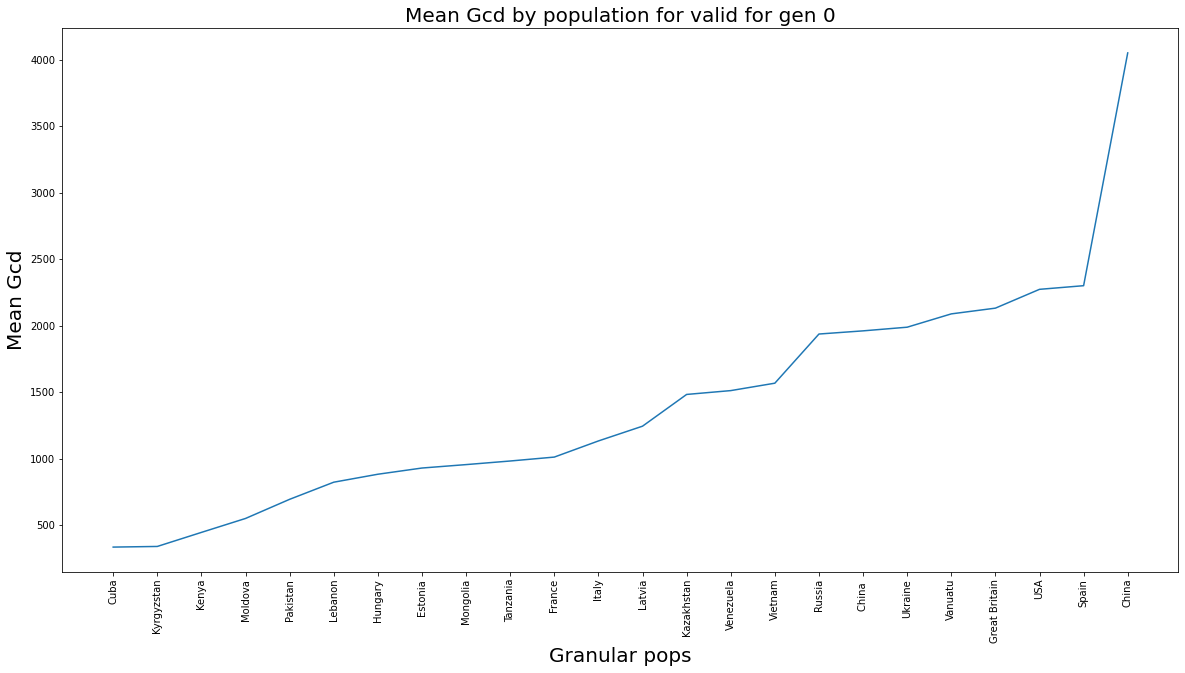

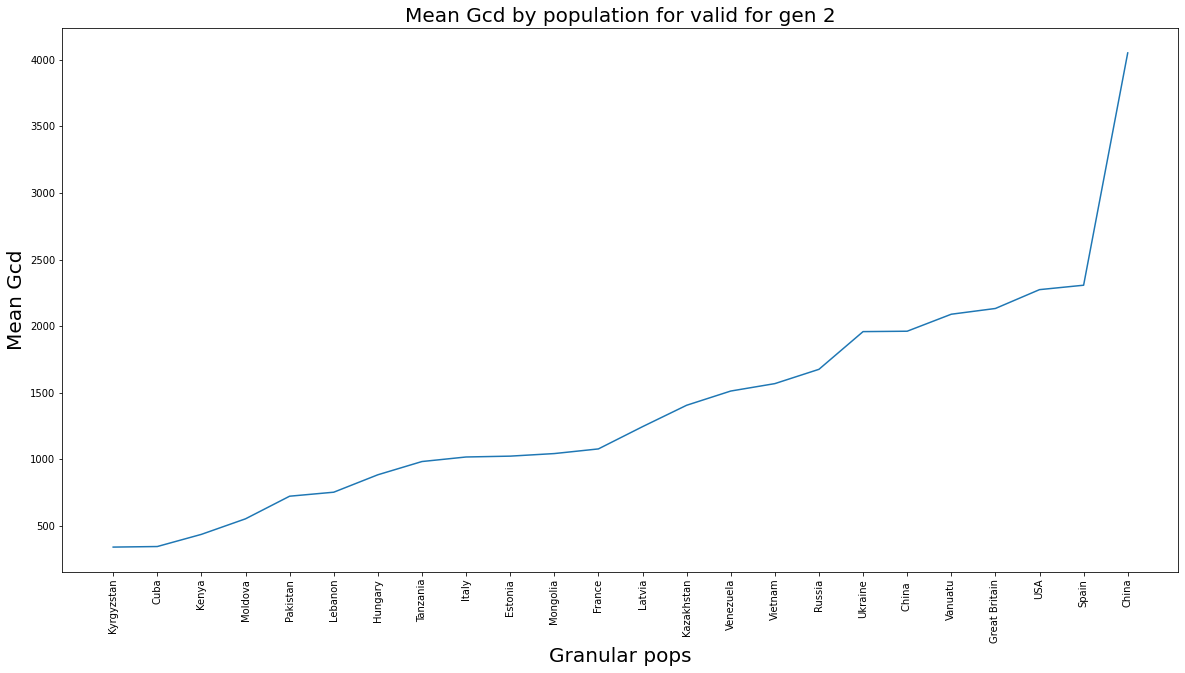

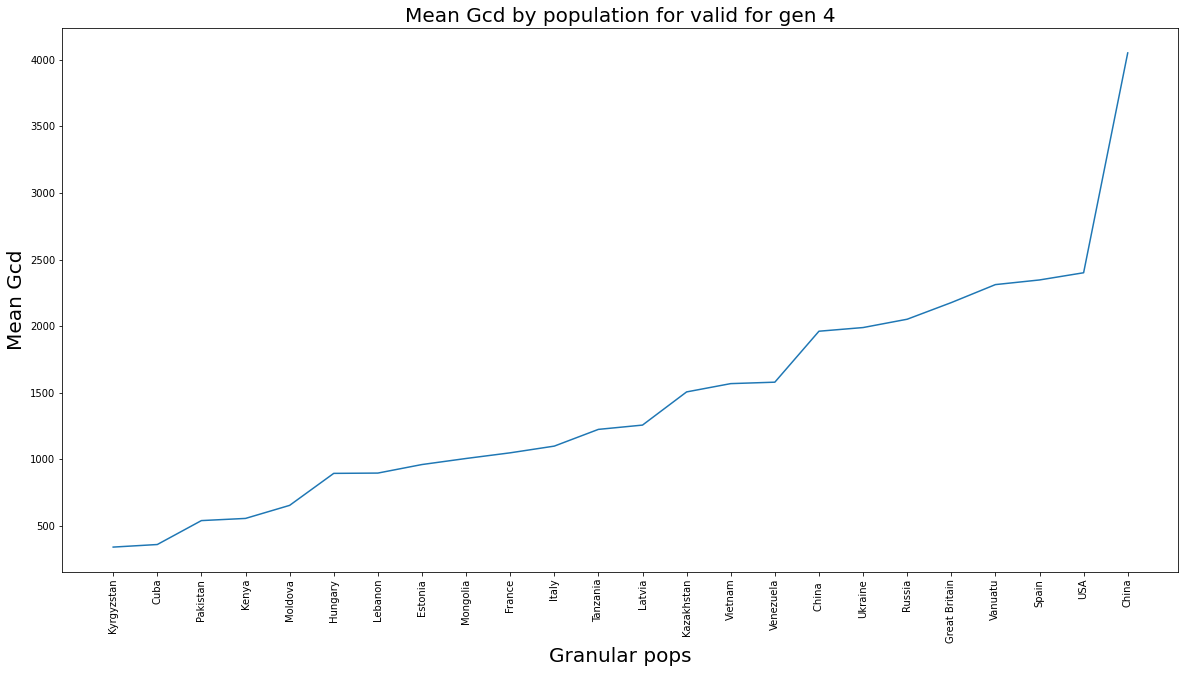

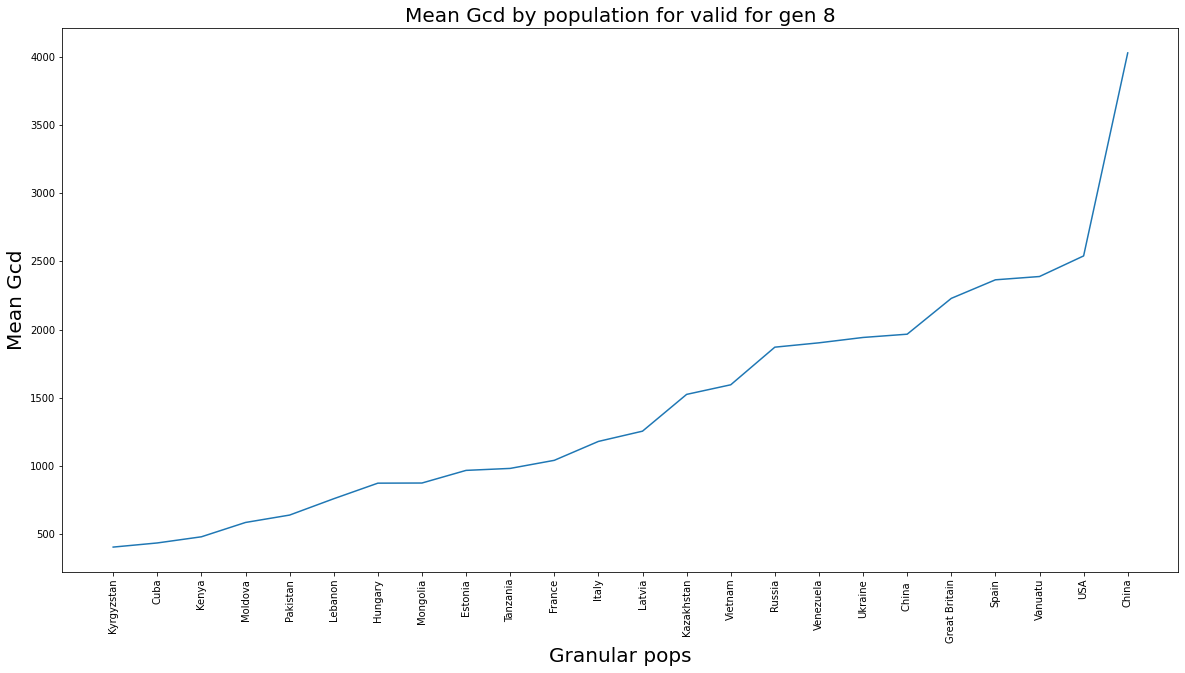

In [313]:
dataset='valid'
for gen in [[0], [2],[4],[8]]:
    plt.rcParams["figure.figsize"] = (20,10)
    gen_balancedGcd_dict={rev_pop_dict[k]:v for k,v in \
    results_valid['Model_H_exp_id_2_data_id_4_geo'][str(gen)]['balancedGcdMatrix'].items()}
    #sort the dict by gcd
    gen_balancedGcd_ls=sorted(gen_balancedGcd_dict.items(), key=lambda item:item[1])
    x, y=zip(*gen_balancedGcd_ls)
    plt.plot(x,y)
    plt.xlabel('Granular pops', fontsize=20)
    plt.xticks(rotation=90)
    plt.ylabel('Mean Gcd', fontsize=20)
    plt.title(f"Mean Gcd by population for {dataset} for gen {gen[0]}", fontsize=20)
    plt.show()

In [21]:
# dataset='test'
# for gen in [[0], [2],[4],[8]]:
#     plt.rcParams["figure.figsize"] = (20,10)
#     gen_balancedGcd_dict={rev_pop_dict[k]:v for k,v in \
#     results_test['Model_O_exp_id_8_data_id_1_geo'][str(gen)]['balancedGcdMatrix'].items()}
#     #sort the dict by gcd
#     gen_balancedGcd_ls=sorted(gen_balancedGcd_dict.items(), key=lambda item:item[1])
#     x, y=zip(*gen_balancedGcd_ls)
#     plt.plot(x,y)
#     plt.xlabel('Granular pops', fontsize=20)
#     plt.xticks(rotation=90)
#     plt.ylabel('Mean Gcd', fontsize=20)
#     plt.title(f"Mean Gcd by population for {dataset} for gen {gen[0]}", fontsize=20)
#     plt.show()

# visualization (Map for geography)

In [385]:

labels_path = osp.join(os.environ['OUT_PATH'], geno_type,'labels/data_id_4_geo')
data_path = osp.join(os.environ['OUT_PATH'], geno_type, 'labels/data_id_4_geo')
models_path=osp.join(os.environ['OUT_PATH'], geno_type, 'training/Model_H_exp_id_3_data_id_4_geo/') 
dataset_type='valid'
config={}
config['data.labels']=labels_path 
config['data.dir']=data_path 
config['models.dir']=models_path
config['data.dataset_type']=dataset_type
config['cuda']='cuda'
config['model.loadBest']=True
json_path = osp.join(config['models.dir'], 'params.yaml')
assert osp.isfile(json_path), "No json configuration file found at {}".format(json_path)
params = Params(json_path)
params.rtnOuts=True
params.mc_dropout=False
params.mc_samples=100
params.cp_tol=1
params.test_gens=[0,2,4,8]
params.evalCp=True
params.evalBalancedGcd=True
params.evalExtraMainLosses=True
results, test_dataset, model, _=inference.main(config, params)


INFO: __init__:src.main.dataset: Loading valid Dataset
INFO: __init__:src.main.dataset:Loading gen 0
INFO: __init__:src.main.dataset: snps data: (112, 16416)
INFO: __init__:src.main.dataset: y_labels data :(112, 16416)
INFO: __init__:src.main.dataset:Loading gen 2
INFO: __init__:src.main.dataset: snps data: (800, 16416)
INFO: __init__:src.main.dataset: y_labels data :(800, 16416)
INFO: __init__:src.main.dataset:Loading gen 4
INFO: __init__:src.main.dataset: snps data: (800, 16416)


 device used: cuda
Loading the datasets...


INFO: __init__:src.main.dataset: y_labels data :(800, 16416)
INFO: __init__:src.main.dataset:Loading gen 8
INFO: __init__:src.main.dataset: snps data: (800, 16416)
INFO: __init__:src.main.dataset: y_labels data :(800, 16416)
INFO: transform_data:src.main.dataset:Transforming the data


Finished '_geoConvertLatLong2nVec' in 0.0055 secs
Finished 'mapping_func' in 0.0233 secs
Finished 'pop_mapping' in 0.0092 secs
Finished 'pop_mapping' in 0.0091 secs
Finished 'transform_data' in 2.6378 secs
Finished '__init__' in 3.1819 secs
Parameter count for model AuxNetwork:1619003
Parameter count for model PositionalEncoding:0
Parameter count for model attention_single:32342
Parameter count for model FFNN:28492
Parameter count for model BiRNN:25283
Parameter count for model logits_Block:2289
Total parameters:1707409
Finished 'load_model' in 0.0196 secs
best val loss metrics : {'loss_main': 1148.7813868431529, 'loss_aux': 2870.7487559713377, 'l1_loss': 0.27315462318954953, 'mse': 0.05931933214710017, 'smooth_l1': 0.029648422625414124, 'weighted_loss': 0.27315462318954953}
at epoch : 47
train loss metrics: {'loss_main': 426.51722367910685, 'loss_aux': 815.768280857379, 'l1_loss': 0.09983692130268566, 'mse': 0.008701525532696918, 'smooth_l1': 0.004350268213753395, 'weighted_loss': 0.0

In [335]:
results_coord_main=results.t_out.coord_main.mean(0)
print(f"shape of coord main:{results_coord_main.shape}")
y_pred = results_coord_main
n_vec_dim=y_pred.shape[-1]
data_tensor = torch.tensor(y_pred).float()
batch_size_cpd = data_tensor.shape[0]
mu_prior = torch.zeros((batch_size_cpd, 1,n_vec_dim))
mean_var=torch.mean(torch.var(data_tensor, dim =1),dim=0).unsqueeze(0)
cov_prior = (mean_var.repeat(batch_size_cpd,1).unsqueeze(1)* torch.eye(n_vec_dim)).reshape(batch_size_cpd,1,n_vec_dim,n_vec_dim)
cov_x = cov_prior
likelihood_model = Multivariate_Gaussian(mu_prior, cov_prior, cov_x)
T = params.n_win
model_cpd = BOCD.BOCD(None, T, likelihood_model, batch_size_cpd)
_,_,_,_=model_cpd.run_recursive(data_tensor, 'cpu')

shape of coord main:(2512, 32, 3)
Finished 'run_recursive' in 1.6919 secs


In [336]:
granular_pop_dict = load_path(osp.join(labels_path, 'granular_pop.pkl'), en_pickle=True)
superop_dict=load_path(osp.join(labels_path, 'superpop.pkl'), en_pickle=True)
pop_sample_map=pd.read_csv(osp.join(labels_path, 'pop_sample_map.tsv'),sep="\t")
pop_arr=repeat_pop_arr(pop_sample_map)
cp_target=test_dataset.data['cps']
seqlen=cp_target.shape[1]
rev_pop_dict={v:k for k,v in granular_pop_dict.items()}

In [397]:
index=2461
print(index)
true_cpsSample=cp_target[index,:]
y_predSample=results_coord_main[index,:]
y_trueSample=test_dataset.data['y'][index,:]
granularpopSample=test_dataset.data['granular_pop'][index,:]
namesSample=[rev_pop_dict[i] for i in granularpopSample.astype(int)]

2461


In [398]:
predBOCDSample=model_cpd.cp[index,:]
pred_cps_BOCD=getCpPred(cpMethod.BOCD.name, predBOCDSample, 5.0, 1, len(true_cpsSample))
pred_cps_BOCD=pred_cps_BOCD.squeeze(0).detach().cpu().numpy()# squeeze the batch dimension of 1

cpIdx=np.nonzero(pred_cps_BOCD)[0]
remWin=3
for i in cpIdx:
    low=max(0,i-remWin)
    high=min(seqlen, i+remWin)
    pred_cps_BOCD[low:high]=1

In [399]:
mappedSpArr=nearestNeighbourMapping(labels_path, y_predSample.reshape(-1,3))
y_predsTrue=test_dataset.data['y'].reshape(-1,3)
superpopsTrue=test_dataset.data['superpop'].reshape(-1,)

Finished 'nearestNeighbourMapping' in 0.0158 secs


number of changepoints removed:6,0.1875


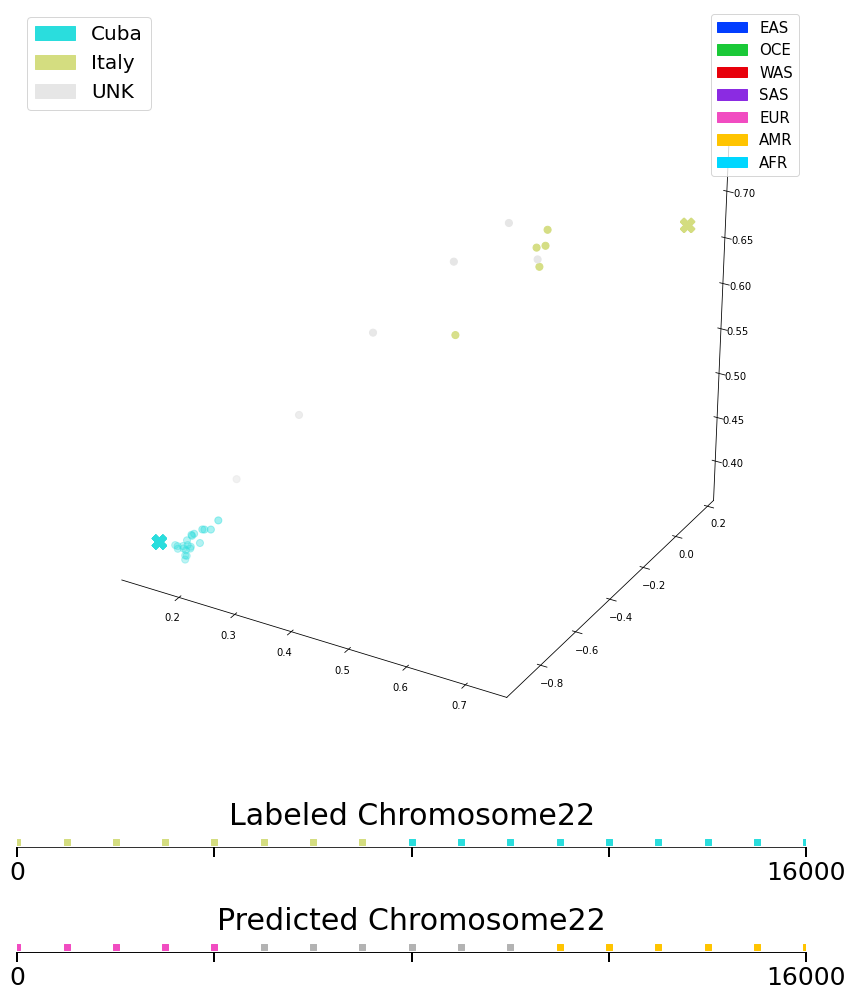

In [400]:
plot_sample(namesSample, y_predSample, y_trueSample, superop_dict, params.chmlen, pred_cps=pred_cps_BOCD,\
            mappedSpArr=mappedSpArr)

In [401]:
lbl_coord=convert_coordinates(y_trueSample[:,0], y_trueSample[:,1], y_trueSample[:,2])
pred_coord=convert_coordinates(y_predSample[:,0], y_predSample[:,1], y_predSample[:,2])
granularPopNames=namesSample
plot_coordinates_map(granularPopNames, pred_coord, lbl_coord, pred_cps=pred_cps_BOCD, cpShow=True)

# Changepoint accuracy comparison

In [379]:
params.mc_dropout=True
params.mc_samples=100
results, test_dataset, model, _=inference.main(config, params)

INFO: __init__:src.main.dataset: Loading valid Dataset
INFO: __init__:src.main.dataset:Loading gen 0
INFO: __init__:src.main.dataset: snps data: (112, 16416)
INFO: __init__:src.main.dataset: y_labels data :(112, 16416)
INFO: __init__:src.main.dataset:Loading gen 2
INFO: __init__:src.main.dataset: snps data: (800, 16416)
INFO: __init__:src.main.dataset: y_labels data :(800, 16416)
INFO: __init__:src.main.dataset:Loading gen 4
INFO: __init__:src.main.dataset: snps data: (800, 16416)
INFO: __init__:src.main.dataset: y_labels data :(800, 16416)


 device used: cuda
Loading the datasets...


INFO: __init__:src.main.dataset:Loading gen 8
INFO: __init__:src.main.dataset: snps data: (800, 16416)
INFO: __init__:src.main.dataset: y_labels data :(800, 16416)
INFO: transform_data:src.main.dataset:Transforming the data


Finished '_geoConvertLatLong2nVec' in 0.0053 secs
Finished 'mapping_func' in 0.0214 secs
Finished 'pop_mapping' in 0.0087 secs
Finished 'pop_mapping' in 0.0085 secs
Finished 'transform_data' in 2.6083 secs
Finished '__init__' in 3.1136 secs
Parameter count for model AuxNetwork:1619003
Parameter count for model PositionalEncoding:0
Parameter count for model attention_single:32342
Parameter count for model FFNN:28492
Parameter count for model BiRNN:25283
Parameter count for model logits_Block:2289
Total parameters:1707409
Finished 'load_model' in 0.0187 secs
best val loss metrics : {'loss_main': 1148.7813868431529, 'loss_aux': 2870.7487559713377, 'l1_loss': 0.27315462318954953, 'mse': 0.05931933214710017, 'smooth_l1': 0.029648422625414124, 'weighted_loss': 0.27315462318954953}
at epoch : 47
train loss metrics: {'loss_main': 426.51722367910685, 'loss_aux': 815.768280857379, 'l1_loss': 0.09983692130268566, 'mse': 0.008701525532696918, 'smooth_l1': 0.004350268213753395, 'weighted_loss': 0.0

In [343]:
@timer
def prMetricsByThresh(method_name, cp_pred_raw, cp_target, steps, minThresh, maxThresh, win_tol=2, byWindows=False):
    increment = (maxThresh - minThresh)/steps
    df=pd.DataFrame(columns=list(t_prMetrics._fields)+['thresh'])
    for thresh in np.arange(minThresh, maxThresh + increment, increment):
        prMetrics, cp_pred = reportChangePointMetrics(method_name, cp_pred_raw, cp_target, thresh, win_tol)
        if byWindows: 
            prMetrics={}
            prMetrics['Precision']=precision_score(cp_target.flatten(), cp_pred.flatten())
            prMetrics['Recall']=recall_score(cp_target.flatten(), cp_pred.flatten())
            prMetrics['BalancedAccuracy']=balanced_accuracy_score(cp_target.flatten(), cp_pred.flatten())
            prMetrics['Accuracy']=accuracy_score(cp_target.flatten(), cp_pred.flatten())
            prMetrics['A_major']=(2*prMetrics['BalancedAccuracy'])-prMetrics['Recall']
        prMetrics['thresh']=thresh
        prMetrics['F1']=2*prMetrics['Precision']*prMetrics['Recall']/(prMetrics['Precision']+prMetrics['Recall'])
        df=df.append(prMetrics, ignore_index=True)
    return df

In [344]:
results_coord_main=results.t_out.coord_main.mean(0)
print(f"shape of coord main:{results_coord_main.shape}")
y_pred = results_coord_main
n_vec_dim=y_pred.shape[-1]
data_tensor = torch.tensor(y_pred).float()
batch_size_cpd = data_tensor.shape[0]
mu_prior = torch.zeros((batch_size_cpd, 1,n_vec_dim))
mean_var=torch.mean(torch.var(data_tensor, dim =1),dim=0).unsqueeze(0)
cov_prior = (mean_var.repeat(batch_size_cpd,1).unsqueeze(1)* torch.eye(n_vec_dim)).reshape(batch_size_cpd,1,n_vec_dim,n_vec_dim)
cov_x = cov_prior
likelihood_model = Multivariate_Gaussian(mu_prior, cov_prior, cov_x)
T = params.n_win
model_cpd = BOCD.BOCD(None, T, likelihood_model, batch_size_cpd)
_,_,_,_=model_cpd.run_recursive(data_tensor, 'cpu')

shape of coord main:(2512, 32, 3)
Finished 'run_recursive' in 1.4738 secs


In [345]:
df_nn=prMetricsByThresh(cpMethod.neural_network.name, torch.tensor(results.t_out.cp_logits).float(), \
                        torch.tensor(test_dataset.data['cps']).unsqueeze(2).float(), 20, 0, 0.85)
df_nn.style.background_gradient(cmap="Blues")

/share/software/user/open/py-jupyter/1.0.0_py36/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning:

invalid value encountered in double_scalars



Finished 'prMetricsByThresh' in 0.6453 secs


,Precision,Recall,Accuracy,A_major,BalancedAccuracy,thresh,F1
0,0.0017475316115986169,1.0,0.005112957802547771,0.003377199541398734,0.501689,0.000000,0.003489
1,0.004006887873369097,0.8642857142857143,0.6255971337579618,0.6251806988684512,0.744733,0.042500,0.007977
2,0.005321170657544659,0.3,0.9011121616242038,0.9021609092268581,0.601080,0.085000,0.010457
3,0.005707297187117815,0.3,0.9077552746815286,0.9088156123822342,0.604408,0.127500,0.011201
4,0.005711954304365565,0.3,0.9078299164012739,0.9088903843278002,0.604445,0.170000,0.011210
5,0.005712731229597388,0.3,0.9078423566878981,0.9089028463187279,0.604451,0.212500,0.011212
6,0.005713508366208679,0.3,0.9078547969745223,0.9089153083096555,0.604458,0.255000,0.011213
7,0.005713508366208679,0.3,0.9078547969745223,0.9089153083096555,0.604458,0.297500,0.011213
8,0.005713508366208679,0.3,0.9078547969745223,0.9089153083096555,0.604458,0.340000,0.011213
9,0.0,0.0,0.9982459195859873,0.9999875380090724,0.499994,0.382500,nan


In [346]:
print(results.t_out.coord_main.shape, results.t_out.cp_logits.shape, pred_cps_BOCD.shape)
df_grad=prMetricsByThresh(cpMethod.gradient.name, torch.tensor(results_coord_main).float(), \
                        torch.tensor(test_dataset.data['cps']).unsqueeze(2).float(), 20, 0,1)
df_grad.style.background_gradient(cmap="Blues")

(100, 2512, 32, 3) (2512, 32, 1) (32,)


/share/software/user/open/py-jupyter/1.0.0_py36/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning:

invalid value encountered in double_scalars



Finished 'prMetricsByThresh' in 0.6007 secs


,Precision,Recall,Accuracy,A_major,BalancedAccuracy,thresh,F1
0,0.001804030720065976,1.0,0.03632563694267516,0.03464433477892428,0.517322,0.000000,0.003602
1,0.009156149467953477,0.2642857142857143,0.9489077428343949,0.9501021883256069,0.607194,0.050000,0.017699
2,0.016286644951140065,0.14285714285714285,0.9834792993630573,0.9849459149593739,0.563902,0.100000,0.029240
3,0.020930232558139535,0.06428571428571428,0.9931329617834395,0.9947535018194507,0.529520,0.150000,0.031579
4,0.03773584905660377,0.04285714285714286,0.9964296377388535,0.9980933153880664,0.520475,0.200000,0.040134
5,0.4,0.04285714285714286,0.9982210390127388,0.9998878420816509,0.521372,0.250000,0.077419
6,0.5714285714285714,0.02857142857142857,0.9982708001592356,0.999962614027217,0.514267,0.300000,0.054422
7,0.6666666666666666,0.02857142857142857,0.9982832404458599,0.9999750760181446,0.514273,0.350000,0.054795
8,0.6666666666666666,0.02857142857142857,0.9982832404458599,0.9999750760181446,0.514273,0.400000,0.054795
9,1.0,0.014285714285714285,0.9982832404458599,1.0,0.507143,0.450000,0.028169


In [347]:
df_bocd=prMetricsByThresh(cpMethod.BOCD.name, model_cpd.cp, \
                        torch.tensor(test_dataset.data['cps']).unsqueeze(2).float(), 20,1,10)
df_bocd.style.background_gradient(cmap="Blues")

Finished 'prMetricsByThresh' in 0.8748 secs


,Precision,Recall,Accuracy,A_major,BalancedAccuracy,thresh,F1
0,0.045454545454545456,0.03571428571428571,0.9970143312101911,0.9986914909525946,0.517203,1.000000,0.040000
1,0.045454545454545456,0.03571428571428571,0.9970143312101911,0.9986914909525946,0.517203,1.450000,0.040000
2,0.045454545454545456,0.03571428571428571,0.9970143312101911,0.9986914909525946,0.517203,1.900000,0.040000
3,0.05625,0.06428571428571428,0.9964918391719745,0.9981182393699217,0.531202,2.350000,0.060000
4,0.05625,0.06428571428571428,0.9964918391719745,0.9981182393699217,0.531202,2.800000,0.060000
5,0.07647058823529412,0.09285714285714286,0.9964669585987261,0.9980434674243557,0.545450,3.250000,0.083871
6,0.07647058823529412,0.09285714285714286,0.9964669585987261,0.9980434674243557,0.545450,3.700000,0.083871
7,0.07653061224489796,0.10714285714285714,0.9961932722929936,0.9977443796420916,0.552444,4.150000,0.089286
8,0.07653061224489796,0.10714285714285714,0.9961932722929936,0.9977443796420916,0.552444,4.600000,0.089286
9,0.08695652173913043,0.12857142857142856,0.9961310708598726,0.9976446837146703,0.563108,5.050000,0.103746


In [348]:
nnThresh=0.4
gradThresh=0.1 
varThresh=0.025
bocdThresh=5.0
cpThresh=[nnThresh, gradThresh, varThresh, bocdThresh]

In [349]:
granular_pop_dict = load_path(osp.join(labels_path, 'granular_pop.pkl'), en_pickle=True)
cp_target=test_dataset.data['cps']
seqlen=cp_target.shape[1]
rev_pop_dict={v:k for k,v in granular_pop_dict.items()}
cp_pred_raw=[torch.tensor(results.t_out.cp_logits).float(), torch.tensor(results_coord_main).float(), 
             torch.tensor(results.t_out.y_var).float(), model_cpd.cp]
pred_cps = {}
for name, thresh, pred_raw in zip([cp.name for cp in cpMethod], cpThresh, cp_pred_raw):
    _, pred_cps[name]= reportChangePointMetrics(name, pred_raw, cp_target, thresh)

true_cps=cp_target
pred_cps={k:v.detach().cpu().numpy() for k,v in pred_cps.items()}

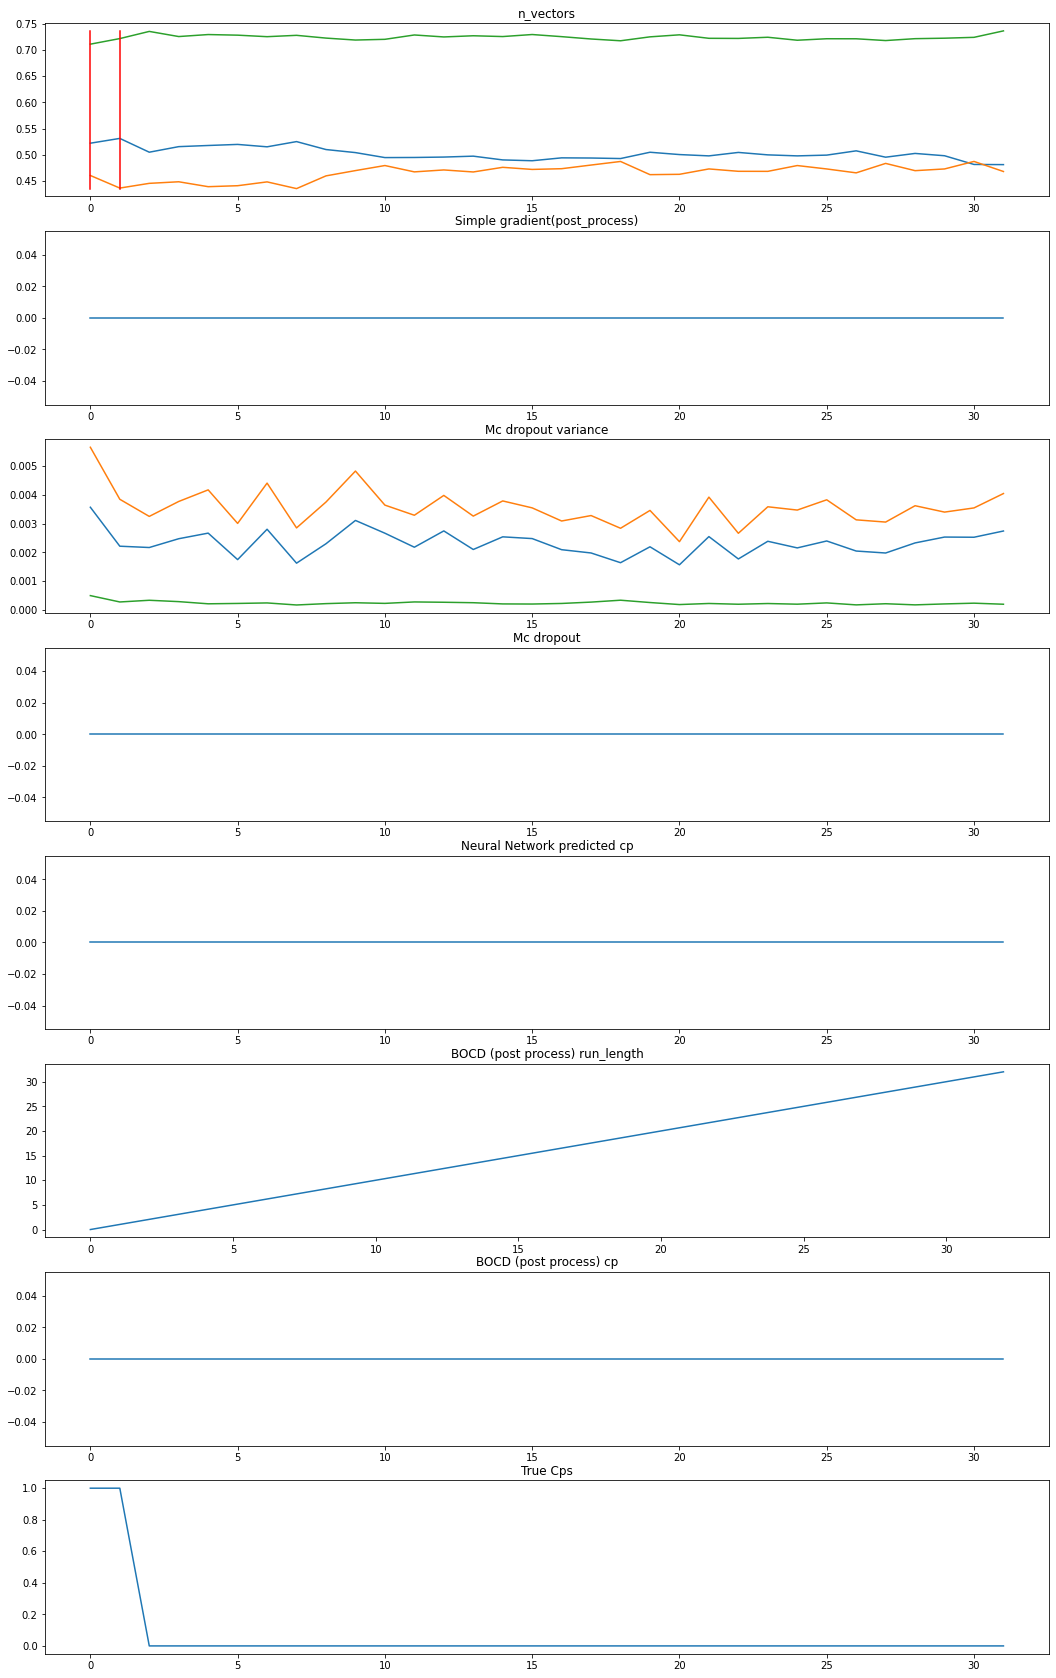

In [367]:
true_cpsSample=true_cps[index,:]
pred_cpsSample={k:v[index,:] for k,v in pred_cps.items()}
y_predSample=results_coord_main[index,:]
y_varSample=results.t_out.y_var[index,:,:]
bocp_rlSample=model_cpd.cp.detach().cpu().numpy()[index,:]
granularpopSample=test_dataset.data['granular_pop'][index,:]
namesSample=[rev_pop_dict[i] for i in granularpopSample.astype(int)]
plot_changepoints(true_cpsSample, pred_cpsSample, y_predSample, bocp_rlSample, y_varSample, namesSample)

In [391]:
np.where(test_dataset.data['cps']==1)

(array([ 136,  136,  224,  224,  310,  310,  322,  322,  626,  626,  632,
         632,  792,  792,  921,  921,  971,  971,  989,  989, 1005, 1005,
        1074, 1074, 1144, 1144, 1158, 1158, 1265, 1265, 1310, 1310, 1330,
        1330, 1366, 1366, 1378, 1378, 1383, 1383, 1419, 1419, 1450, 1450,
        1476, 1476, 1492, 1492, 1572, 1572, 1586, 1586, 1595, 1595, 1644,
        1644, 1674, 1674, 1724, 1724, 1749, 1749, 1759, 1759, 1783, 1783,
        1791, 1791, 1806, 1806, 1824, 1824, 1852, 1852, 1853, 1853, 1890,
        1890, 1938, 1938, 1959, 1959, 1983, 1983, 1988, 1988, 1994, 1994,
        2008, 2008, 2014, 2014, 2028, 2028, 2093, 2093, 2098, 2098, 2115,
        2115, 2173, 2173, 2177, 2177, 2179, 2179, 2196, 2196, 2204, 2204,
        2226, 2226, 2236, 2236, 2244, 2244, 2266, 2266, 2277, 2277, 2278,
        2278, 2286, 2286, 2335, 2335, 2378, 2378, 2382, 2382, 2430, 2430,
        2458, 2458, 2461, 2461, 2484, 2484, 2506, 2506]),
 array([ 6,  7, 24, 25,  0,  1, 25, 26,  2,  3, 12, 13

In [311]:
np.sum(np.sum(test_dataset.data['cps'],axis=1)!=0), np.sum(np.sum(test_dataset.data['cps'],axis=1))

(73, 146)

In [8]:
vcf = allel.read_vcf(osp.join(os.environ.get('IN_PATH'), 'humans/master_vcf_files/ref_final_beagle_phased_1kg_hgdp_sgdp_chr22.vcf.gz'))

In [9]:
vcf

{'calldata/GT': array([[[1, 0],
         [0, 0],
         [1, 0],
         ...,
         [1, 1],
         [1, 1],
         [1, 1]],
 
        [[0, 1],
         [1, 1],
         [0, 0],
         ...,
         [0, 0],
         [0, 0],
         [0, 1]],
 
        [[1, 0],
         [0, 0],
         [1, 0],
         ...,
         [1, 1],
         [1, 1],
         [1, 1]],
 
        ...,
 
        [[0, 0],
         [0, 0],
         [0, 0],
         ...,
         [1, 1],
         [0, 0],
         [0, 0]],
 
        [[0, 0],
         [0, 0],
         [0, 0],
         ...,
         [0, 0],
         [0, 0],
         [0, 0]],
 
        [[0, 0],
         [0, 0],
         [0, 0],
         ...,
         [0, 0],
         [0, 0],
         [0, 0]]], dtype=int8),
 'samples': array(['HG00096', 'HG00097', 'HG00099', ..., 'LP6005677-DNA_A03',
        'LP6005592-DNA_H01', 'LP6005592-DNA_G01'], dtype=object),
 'variants/ALT': array([['A', '', ''],
        ['G', '', ''],
        ['G', '', ''],
        ...,
  